# Monitor MetaD simulations

## Input
* `SimulationData` object with CV, dihedral grids
* `Metadynamics` object files after each simulation

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import openmm.unit as unit

from src.filenames import FileNames
from src.data import OpenMMData
from src.util import SimulationParametersMetaD, load_npz
from src.util import sgrids, bias_dihedral_grid, bias_cvs_grid


p = SimulationParametersMetaD(
    simulation_time = 0.1 * unit.nanosecond, 
    report_interval_time = 1 * unit.picosecond,
    num_simulations = 100 # 300
)
fn = FileNames('data/ala2_metad', p.ns)
# fn = FileNames('data/ala2_metad_vac', p.ns)
sd = OpenMMData('data/ala2_solv')

s1_grid, s2_grid = sgrids(sd.cvs, pad=0.25)

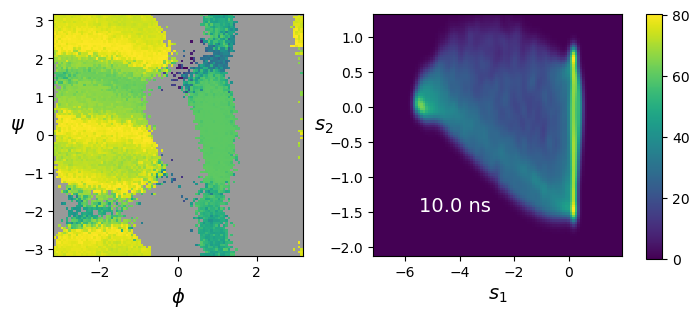

In [3]:
def plot_bias_dihedral_cvs(axr, theta, bias_dihedral, s1, s2, bias_cvs, label=None):
    ax = axr[0]
    cb = ax.pcolormesh(theta, theta, bias_dihedral.T)
    ax.set_xlabel(r'$\phi$', fontsize=14)
    ax.set_ylabel(r'$\psi$', fontsize=14, rotation=0)
    ax.patch.set_facecolor('0.6')
    ax = axr[1]
    cb = ax.pcolormesh(s1, s2, bias_cvs.T)
    ax.set_xlabel("$s_1$", fontsize=14)
    ax.set_ylabel("$s_2$", fontsize=14, rotation=0)
    if label:
        ax.text(-5.5, -1.5, label, color='white', fontsize=14)
    return cb


sim_num = 99
ns = (sim_num + 1) / 10
label = f'{ns} ns'
filename = f'figures/metad-bias-{ns}.png'

metad = load_npz(fn.metad_kde(sim_num))
bias_dihedral = bias_dihedral_grid(sd.cvs_grid, metad)
bias_cvs = bias_cvs_grid(s1_grid, s2_grid, metad)
    
fig, axs = plt.subplots(1, 2, figsize=(8, 3.5))
cb = plot_bias_dihedral_cvs(axs, sd.theta_grid, bias_dihedral, s1_grid, s2_grid, bias_cvs, label=label)
fig.tight_layout(pad=2.0)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.22, 0.02, 0.7])
fig.colorbar(cb, cax=cbar_ax)
# fig.savefig(filename, bbox_inches='tight')

## Vertically aligned

In [121]:
# fig, axs = plt.subplots(2, 1, figsize=(5, 8))
# cb = plot_bias_dihedral_cvs(axs, sd.theta_grid, bias_dihedral, s1_grid, s2_grid, bias_cvs, label=label)
# fig.tight_layout(pad=2.0)
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.83, 0.22, 0.02, 0.7])
# fig.colorbar(cb, cax=cbar_ax)
# fig.savefig(f'figures/metad-bias-{ns}-vert.png', bbox_inches='tight')

# Visualize the time-evolution of bias potential over short trajectory

In [4]:
# sim_frames = [0, 1, 2, 3, 4, 5]
# sim_labels = ['0.1 ns', '0.2 ns', '0.3 ns', '0.4 ns', '0.5 ns', '0.6 ns']
# metads = [load_npz(fn.metad_kde(frame)) for frame in sim_frames]

# num_plots = 3
# fig, axs = plt.subplots(num_plots, 2, figsize=(8, 3.5 * num_plots))
# for axr, metad, label in zip(axs, metads[:num_plots], sim_labels[:num_plots]):
#     bias_dihedral = bias_dihedral_grid(sd.cvs_grid, metad)
#     bias_cvs = bias_cvs_grid(s1_grid, s2_grid, metad)
#     # cb = plot_bias_dihedral_cvs(axr, sd.theta_grid, bias_dihedral, s1_grid, s2_grid, bias_cvs, label=label)
#     cb = plot_bias_dihedral_cvs(axr, sd.theta_grid, bias_dihedral, s1_grid, s2_grid, bias_cvs, label=label)
    
# # cb = plot_bias_dihedral_cvs(axs, sd.theta_grid, bias_dihedral, s1_grid, s2_grid, bias_cvs)
# fig.tight_layout(pad=2.0)
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.83, 0.28, 0.02, 0.5])
# fig.colorbar(cb, cax=cbar_ax)

# fig.savefig('figures/metad-bias-3.png', bbox_inches='tight')

# Look at enhanced sampling: transition rates

In [55]:
from src.util import gaussian_centers_from_metad, macrostates_core, transition_times

centers = gaussian_centers_from_metad(fn, p.num_simulations)
centers = np.vstack([c for c in centers])

states = macrostates_core(centers)
tau_G = (p.steps_per_gaussian * p.timestep).in_units_of(unit.nanosecond)._value

times_abs = transition_times(states, tau_G, absolute=True)
times = transition_times(states, tau_G, absolute=False)

states_unbiased = macrostates_core(sd.cvs)
times_unbiased = transition_times(states_unbiased, 0.001, absolute=False)

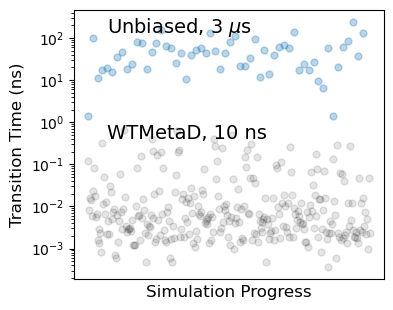

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))
ax.semilogy(range(0, 285, 5), times_unbiased, 'o', markersize=5, color='C0', alpha=0.3)
ax.semilogy(times, 'o', markersize=5, alpha=0.1, color='black')
# ax.text(20, 50, r'Unbiased, 57 Transitions, 3 $\mu$s', fontsize=12)
# ax.text(20, 0.03, r'WTMetaD, 288 Transitions, 10 ns', fontsize=12)
ax.text(20, 130, r'Unbiased, 3 $\mu$s', fontsize=14)
ax.text(20, 0.4, r'WTMetaD, 10 ns', fontsize=14)
ax.set_ylabel('Transition Time (ns)', fontsize=12)
ax.set_xticks([])
ax.set_xlabel('Simulation Progress', fontsize=12)
fig.savefig('figures/enhanced-transitions.png', bbox_inches='tight')

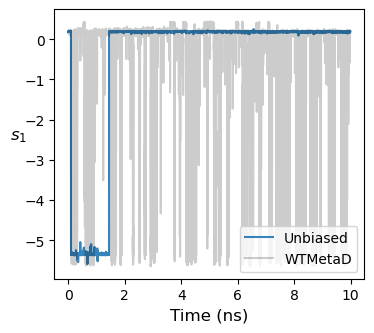

In [125]:
num_points = len(centers) # 10000
time = tau_G * np.arange(num_points)

tau_unbiased = 0.001 # lagtime in ps
time_unbiased = np.arange(0, time[-1], tau_unbiased)

fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))
ax.plot(time_unbiased, sd.cvs[:len(time_unbiased), 0], alpha=0.9, color='C0', label='Unbiased')
ax.plot(time, centers[:num_points, 0], alpha=0.2, color='black', label='WTMetaD')
ax.set_xlabel('Time (ns)', fontsize=12)
ax.set_ylabel(r'$s_1$', rotation=0, fontsize=12)
ax.legend(loc='lower right')
fig.savefig('figures/enhanced-sampling.png', bbox_inches='tight')

In [90]:
sd.cvs.shape

(3000000, 2)

In [79]:
tau_unbiased = 0.001
time_unbiased = np.arange(0, time[-1], tau_unbiased)

array([0. , 0.2, 0.4, 0.6, 0.8])

In [89]:
time[-1]

1.19988

In [83]:
time[time < 2.40000e-04]

array([0.     , 0.00012])